In [1]:
%matplotlib inline
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
from scipy import stats


import json
from datetime import date

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (7, 5.5)



today = date.today().strftime("%Y_%m_%d")

In [3]:
# use flare table from Pineda et al. in prep.
df = pd.read_csv("data/2021_12_08_flares.csv")
df = df[df.real=="1"]
df.head()

,istart,istop,cstart,cstop,tstart,tstop,ed_rec,ed_rec_err,ampl_rec,dur,total_n_valid_data_points,ID,qcs,tstamp,dur_detrend,real
5,13523.0,13530.0,243013.0,243020.0,1564.978889,1564.988611,55.696179,3.928268,0.124217,0.009722,16035,1539914,9,01_12_2021_16_58_28,19.680489,1
6,2724.0,2738.0,230798.0,230812.0,1548.013584,1548.033029,152.094714,5.259690,0.224345,0.019445,16035,1539914,9,01_12_2021_16_58_28,19.680489,1
8,1247.0,1252.0,248546.0,248551.0,1572.663788,1572.670732,33.023852,2.285862,0.097613,0.006945,15734,2470992,10,01_12_2021_16_59_24,17.802888,1
9,10142.0,10149.0,259509.0,259516.0,1587.890238,1587.899960,91.330193,2.346427,0.286523,0.009722,15734,2470992,10,01_12_2021_16_59_24,17.802888,1
10,10455.0,10477.0,259822.0,259844.0,1588.324956,1588.355512,533.533795,4.182289,1.075059,0.030555,15734,2470992,10,01_12_2021_16_59_24,17.802888,1


# Get amplitude from ED

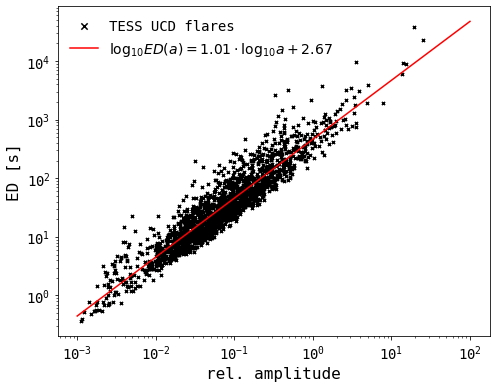

In [4]:
plt.figure()
plt.scatter(df.ampl_rec, df.ed_rec, marker="x",s=10, c="k",label="TESS UCD flares")

slope, intercept, r_value, p_value, std_err = stats.linregress(np.log10(df.ampl_rec.values),
                                                               np.log10(df.ed_rec.values))
x = np.linspace(-3,2,50)
y = x * slope + intercept
plt.plot(10**x,10**y,c="r",label=fr"$\log_{{10}}ED(a)={slope:.2f}\cdot \log_{{10}}a + {intercept:.2f}$")

plt.xscale("log")
plt.yscale("log")
plt.xlabel("rel. amplitude")
plt.ylabel("ED [s]");
plt.legend()
plt.savefig("plots/{today}_ED_over_a_in_TESS_UCD_flares.png", dpi=300)

In [5]:
with open("results/a_from_ed.json", "w") as file:
    dic = { "slope" : slope, "intercept" : intercept }

    json.dump(dic, file)
    print(dic)

{'slope': 1.0052866646875585, 'intercept': 2.665637010161737}


In [6]:
with open("results/a_from_ed.json", "r") as file:
    data = json.load(file)
    
SLOPE_ED_FROM_A = data["slope"]
INTERCEPT_ED_FROM_A = data["intercept"]

In [7]:
def a_from_ed(ed, slope=SLOPE_ED_FROM_A, intercept=INTERCEPT_ED_FROM_A):
    """Calculate amplitude of flare given ED using
    an log-log-linear fit to empirical data.
    
    Parameters:
    -----------
    ed : float or array
        ED
    slope, intercept : float, float
        best-fit values to the ED-a relationship
    
    Return:
    -------
    float or array - relative amplitude of the flare,
     """
    return 10 ** ((np.log10(ed) - intercept) / slope)

In [32]:
def test_a_from_ed():
    """Some simple shape and NaN checks."""
    
    # if ratio is zero return zero
    assert a_from_ed(0.) == 0.

    # enter NaN, get NaN
    assert np.isnan(a_from_ed(np.nan))

    # shape of array is preserved
    assert a_from_ed(np.linspace(10,100,100)).shape[0] == 100

In [33]:
test_a_from_ed()

/tmp/ipykernel_26756/2170951551.py:16: RuntimeWarning: divide by zero encountered in log10
  return 10 ** ((np.log10(ed) - intercept) / slope)


# Get FWHM from amplitude and ED

In [8]:
# Factors extracted from Davenport 2014 rise and decay phases integrated

X = 0.6890 / 1.600 + 0.3030 / 0.2783
f, g, h, i = 1.941, -0.175 ,-2.246,-1.125

def ed_a_from_fwhm_with_davenport(fwhm):
    """Integrate and sum up formulas (1) and (4)
    in Davenport (2014) to obtain ED/amplitude.
    
    Parameters:
    -----------
    fwhm : float or array
        t_1/2 in Davenport (2014)
    
    Return:
    -------
    float or array - ED/amplitude
    """
    return 1 / fwhm**4 * (X * fwhm**5 + fwhm**4 + f / 2 * fwhm**3 + g / 3 * fwhm**2 + h / 4 * fwhm + i / 5)


In [9]:
x = np.logspace(2,5,100)

slope, intercept, r_value, p_value, std_err = stats.linregress(np.log10(x),
                                                               np.log10(ed_a_from_fwhm_with_davenport(x)))
with open("results/fwhm_from_ed_a.json", "w") as file:
    dic = { "slope" : slope, "intercept" : intercept }

    json.dump(dic, file)


{'slope': 0.9993976155140668, 'intercept': 0.18419933578978664}


In [10]:
with open("results/fwhm_from_ed_a.json", "r") as file:
    data = json.load(file)
    
SLOPE_FWHM_FROM_ED_A = data["slope"]
INTERCEPT_FWHM_FROM_ED_A = data["intercept"]

In [11]:
def fwhm_from_ed_a(ed_a, slope=SLOPE_FWHM_FROM_ED_A,
                   intercept=INTERCEPT_FWHM_FROM_ED_A):
    """Calculate FWHM of flare give ED and amplitude using
    an log-log-linear approximation to the polynomial ED(fwhm)
    relation inferred from Davenport (2014).
    
    Parameters:
    -----------
    ed_a : float or array
        ED divided by amplitude
    slope, intercept : float, float
        best-fit values to the relationship
    
    Return:
    -------
    float or array - FWHM of the flare,
    or t_1/2 in the Davenport (2014) model
    """
    return 10 ** ((np.log10(ed_a) - intercept) / slope)

In [28]:
def test_fwhm_from_ed_a():
    """Some simple shape and NaN checks."""
    
    # if ratio is zero return zero
    assert fwhm_from_ed_a(0.) == 0.

    # enter NaN, get NaN
    assert np.isnan(fwhm_from_ed_a(np.nan))

    # shape of array is preserved
    assert fwhm_from_ed_a(np.linspace(10,100,100)).shape[0] == 100

/tmp/ipykernel_26756/1301684946.py:19: RuntimeWarning: divide by zero encountered in log10
  return 10 ** ((np.log10(ed_a) - intercept) / slope)


True

0.0006514504610681996

In [12]:
def decompose_ed_from_UCDs_and_Davenport(ed):
    """Use empirical ED-a relation to get a, then
    Davenport(2014) formulas (1) and (4) integrated
    to infer FWHM.
    
    Parameters:
    ------------
    ed : float or array
        ED of flare
        
    Return:
    -------
    a, fwhm of flare
    """
    a = a_from_ed(ed)
    fwhm = fwhm_from_ed_a(ed/a)
    return a, fwhm

In [21]:
def test_decompose_ed_from_UCDs_and_Davenport():
    """Some simple shape and NaN checks."""

    # check that NaNs stay NaNs
    assert np.isnan(decompose_ed_from_UCDs_and_Davenport(np.nan)).all()

    # check shapes
    a, fwhm = decompose_ed_from_UCDs_and_Davenport(np.logspace(-2,5,100))
    assert a.shape[0] == 100
    assert fwhm.shape[0] == 100


/tmp/ipykernel_26756/2170951551.py:16: RuntimeWarning: divide by zero encountered in log10
  return 10 ** ((np.log10(ed) - intercept) / slope)
/tmp/ipykernel_26756/2228980559.py:16: RuntimeWarning: invalid value encountered in double_scalars
  fwhm = fwhm_from_ed_a(ed/a)


(0.0, nan)

# Delete later maybe

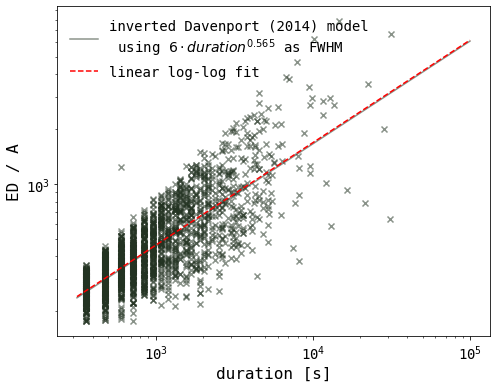

In [13]:
x = np.logspace(2.5,5,100)
plt.plot(x, ed_a_from_fwhm_with_davenport(x**(0.565)*6), label="inverted Davenport (2014) model "
                                              "\n using $6\cdot duration^{0.565}$ as FWHM")
plt.scatter(df.dur * 60 * 60 * 24, df.ed_rec/df.ampl_rec, marker="x", )

slope, intercept, r_value, p_value, std_err = stats.linregress(np.log10(df.dur.values * 60 * 60 * 24),
                                                               np.log10(df.ed_rec.values / df.ampl_rec.values))
x = np.linspace(2.5,5,100)
y = x * slope + intercept
plt.plot(10**x,10**y,c="r", linestyle="dashed", label=f"linear log-log fit")


plt.xscale("log")
plt.yscale("log")
plt.xlabel("duration [s]")
plt.ylabel("ED / A")
plt.legend()

In [14]:

fwhm = 6. * (df.dur * 60 * 60 * 24)**0.565
y = func(fwhm)
plt.scatter(y,df.ed_rec/df.ampl_rec, marker="x",)
plt.plot([1e2,1e4],[1e2,1e4])
plt.xscale("log")
plt.yscale("log")
plt.xlim(1e2,1e4)
plt.ylim(1e2,1e4)
plt.xlabel("ED / A -- inferred")
plt.ylabel("ED / A -- observed")
plt.legend()

NameError: name 'func' is not defined